In [1]:
from LorenzEDMD.EDMD.EDMD import EDMD_CHEB
from typing import List, Tuple
from matplotlib import pyplot as plt
import numpy as np
import pickle
from LorenzEDMD.utils.data_processing import (
    get_spectral_properties , 
    normalise_data_chebyshev, 
    get_acf,
    find_index,
    Koopman_correlation_function)
from LorenzEDMD.dynamical_system.Lorenz import lorenz63
from LorenzEDMD.EDMD.EDMD import TSVD
import matplotlib
import plotly.graph_objects as go

matplotlib.rcParams.update({
    "text.usetex": True,  # Use LaTeX to render text
    "font.family": "serif",  # Use serif font (default in LaTeX)
    "text.latex.preamble": r"\usepackage{amsmath}"  # Optional: better math support
})

In [2]:
with open("./data/edmd.pkl","rb") as f:
    results = pickle.load(f)

EDMDS : List[List[EDMD_CHEB]] = results["edmd results"]
lorenz : lorenz63 = results["lorenz settings"] 

degrees = [x[0].degree for x in EDMDS]
flight_times = [x.flight_time for x in EDMDS[0]]

#### Fix a degree, regularise and get spectral properties

In [3]:
degree_number = -1
degree = degrees[degree_number] 
edmd_flight_times = EDMDS[degree_number]
edmd : EDMD_CHEB = edmd_flight_times[0] 

In [4]:
# Regularisation with TSVDS
tsvd_regulariser = TSVD(rel_threshold=1e-6)
Kreduced = tsvd_regulariser.decompose(edmd)

# Get spectral properties
tsvd_regulariser.get_spectral_properties()
lambdas = np.log(tsvd_regulariser.eigenvalues) / ( lorenz.dt * lorenz.tau * edmd.flight_time)

#### Evaluate correlation functions for Koopman Eigenfunctions

In [40]:
lorenz_cf_traj = lorenz63()
lorenz_cf_traj.noise = lorenz.noise
lorenz_cf_traj.tau = 2
lorenz_cf_traj.t_span = (0,10000)
t, X = lorenz_cf_traj.integrate_EM()
scaled, data_min,data_max = normalise_data_chebyshev(X)

100%|██████████| 2000000/2000000 [00:13<00:00, 146481.74it/s]


In [6]:
PHI = edmd.evaluate_koopman_eigenfunctions_reduced(scaled,tsvd_regulariser)

In [7]:
numbers = [1,3,4,6,8]

/Users/niccolo/anaconda3/lib/python3.10/site-packages/numpy/core/_asarray.py:126: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = array(a, dtype=dtype, order=order, copy=False, subok=subok)


Text(0.5, 0, '$t$')

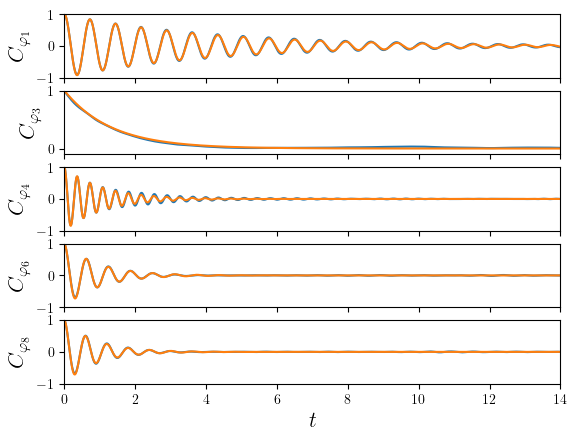

In [8]:
fig , ax = plt.subplots(len(numbers),sharex=True)
nlags = 1500
Dt = lorenz_cf_traj.dt * lorenz_cf_traj.tau * edmd.flight_time
for i,number in enumerate(numbers):
    lags, cf = get_acf(PHI[:,number], nlags = nlags,Dt=Dt)
    cf_th = np.real(np.exp(lambdas[number]*lags))
    ax[i].plot(lags,cf/cf[0])
    ax[i].plot(lags,cf_th /cf_th[0] )
    ax[i].set_xlim(0,14)
    
    ax[i].set_ylim(-1,1)
    if i ==1 :
        ax[i].set_ylim(-0.1,1)
    ax[i].set_ylabel(fr"$C_{{ \varphi_{number} }}$",size=16)
ax[-1].set_xlabel("$t$",size=16)    
#fig.savefig("Correlation_function_Koopman_eigenfunctions.png",dpi=600)

(0.0, 15.0)

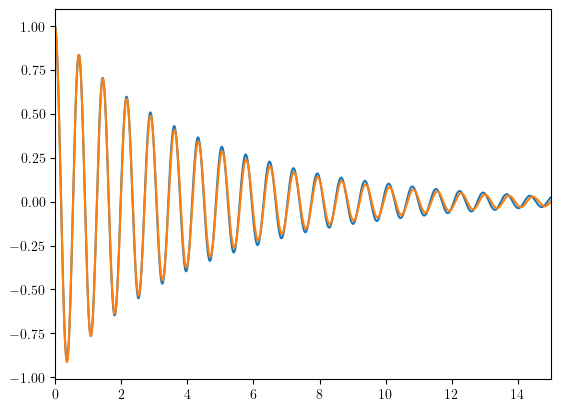

In [9]:
fig , ax = plt.subplots()
nlags = 5000
Dt = lorenz_cf_traj.dt * lorenz_cf_traj.tau * edmd.flight_time

number = 1
lags, cf = get_acf(PHI[:,number], nlags = nlags,Dt=Dt)
cf_th = np.real(np.exp(lambdas[number]*lags))
ax.plot(lags,cf/cf[0])
ax.plot(lags,cf_th /cf_th[0] )
ax.set_xlim(0,15)

### Evaluate correlation functions of observables

In [10]:
z_index = (0,0,1)
xy_index = (1,1,0)
selected_index = z_index

In [11]:
index = find_index(edmd.indices,selected_index)
projections_dictionary = np.zeros(len(edmd.indices))
projections_dictionary[index] = 1

In [12]:
# Project in the r-dimensional space
Gr = tsvd_regulariser.Ur.T @ edmd.G @ tsvd_regulariser.Ur
Mr = tsvd_regulariser.reduced_right_eigvecs.T.conj() @ Gr @ tsvd_regulariser.reduced_right_eigvecs
projections_reduced = tsvd_regulariser.Ur.T @ projections_dictionary

# Thresholding on a subset of modes
tau_threshold = -5
indx = np.where(np.real(lambdas) > tau_threshold)[0] 
lambdas_good = lambdas[indx]

# Projection onto the subspace spanned by the leading n selected modes
Vn = tsvd_regulariser.reduced_right_eigvecs[:,indx]
Mn = Vn.T.conj() @ Gr @ Vn
fn = np.linalg.pinv(Vn.T.conj() @ Gr @ Vn) @ Vn.conj().T @ Gr @ projections_reduced

# Old projection
fnOld = tsvd_regulariser.reduced_left_eigvecs.T.conj() @ projections_reduced

(0.0, 29.0)

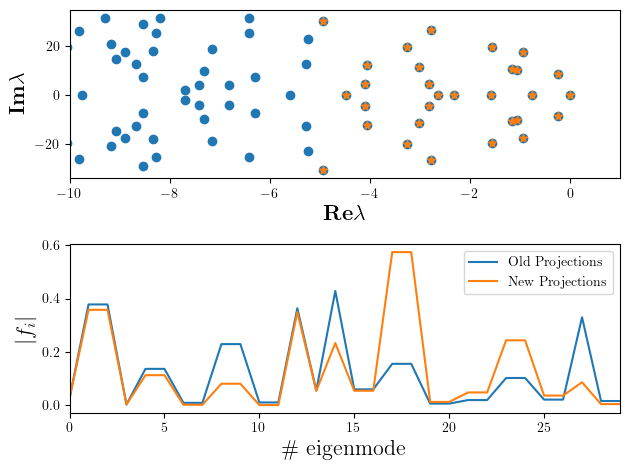

In [13]:
fig, ax = plt.subplots(nrows=2)
ax[0].scatter(np.real(lambdas),np.imag(lambdas))
ax[0].scatter(np.real(lambdas_good), np.imag(lambdas_good),marker="*")
ax[0].set_xlabel(r"$\mathbf{Re}\lambda$",size=16)
ax[0].set_ylabel(r"$\mathbf{Im}\lambda$",size=16)
ax[0].set_xlim(-10,1)

ax[1].plot(np.abs(fn),label="Old Projections")
ax[1].plot(np.abs(fnOld), label = "New Projections")
ax[1].legend()
ax[1].set_xlabel(r"\# eigenmode",size=16)
ax[1].set_ylabel(r"$|f_i|$",size=16)
fig.tight_layout()
ax[1].set_xlim(0,indx[-1])
#fig.savefig("Projections_high.png",dpi=600)

In [14]:
K_corr_old = lambda t: Koopman_correlation_function(t,Mr,fnOld,fnOld,lambdas,to_include=len(lambdas_good))
K_corr_proj = lambda t: Koopman_correlation_function(t,Mn,fn,fn,lambdas_good )

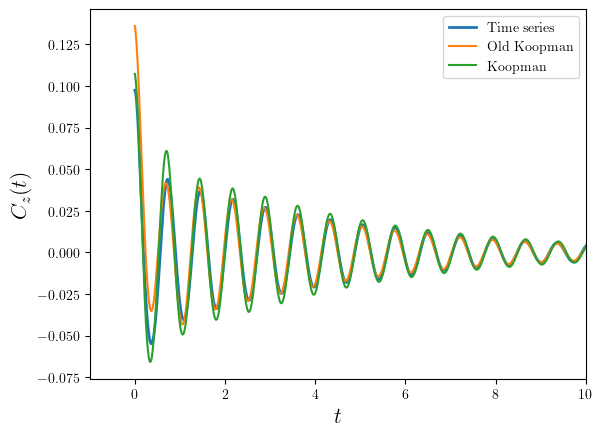

In [15]:
x,y,z = scaled[:,0] , scaled[:,1] , scaled[:,2]
lags, cf = get_acf(z, nlags = nlags,Dt=Dt)
plt.plot(lags,cf  ,label="Time series",linewidth=2)
plt.plot(lags,np.real( [K_corr_old(lag) for lag in lags])   ,label="Old Koopman")
plt.plot(lags,np.real([K_corr_proj(lag) for lag in lags]), label = "Koopman")

plt.xlim(-1,10)
plt.xlabel(r"$t$",size=16)
plt.ylabel(r"$C_{z}(t)$",size=16)
plt.legend()
#plt.ylim(-0.2,0.2)
#plt.savefig("Correlation_function_z_comparison.png",dpi=600)

### Compute the invariant measure

In [70]:
lorenz_resp_traj = lorenz63()
lorenz_resp_traj.noise = lorenz.noise
lorenz_resp_traj.tau = 2
lorenz_resp_traj.t_span = (0,100000)
t, X = lorenz_resp_traj.integrate_EM()
scaled, data_min,data_max = normalise_data_chebyshev(X)

100%|██████████| 20000000/20000000 [02:13<00:00, 149671.04it/s]


In [88]:
L = 200#np.sqrt(scaled.shape[0])  / 5
hist, edges = np.histogramdd(scaled, bins= [int(L)]*3,density=True)
x_centers = 0.5 * (edges[0][1:] + edges[0][:-1])
y_centers = 0.5 * (edges[1][1:] + edges[1][:-1])
z_centers = 0.5 * (edges[2][1:] + edges[2][:-1])

dx = edges[0][1] - edges[0][0]
dy = edges[1][1] - edges[1][0]
dz = edges[2][1] - edges[2][0]
dV = dx * dy * dz

In [89]:
def plot_3d(x_centers,y_centers,z_centers,hist):
    # Create meshgrid
    X, Y, Z = np.meshgrid(x_centers, y_centers, z_centers, indexing='ij')

    # Normalize for color scaling
    hist_norm = hist #/ np.max(hist)

    # Create 3D isosurface
    fig = go.Figure(data=go.Isosurface(
        x=X.flatten(),
        y=Y.flatten(),
        z=Z.flatten(),
        value=hist_norm.flatten(),
        isomin=0.01,
        isomax=1.0,
        surface_count=5,
        colorscale='Viridis',
        caps=dict(x_show=False, y_show=False, z_show=False)
    ))

    fig.update_layout(
        scene=dict(
            xaxis_title='x',
            yaxis_title='y',
            zaxis_title='z'
        ),
        title='Invariant Measure (3D Isosurface)',
        margin=dict(l=0, r=0, b=0, t=30)
    )

    fig.show()

In [90]:
#plot_3d(x_centers,y_centers,z_centers,hist)

In [91]:
sum(hist).sum().sum() * dV

1.0000000000000027

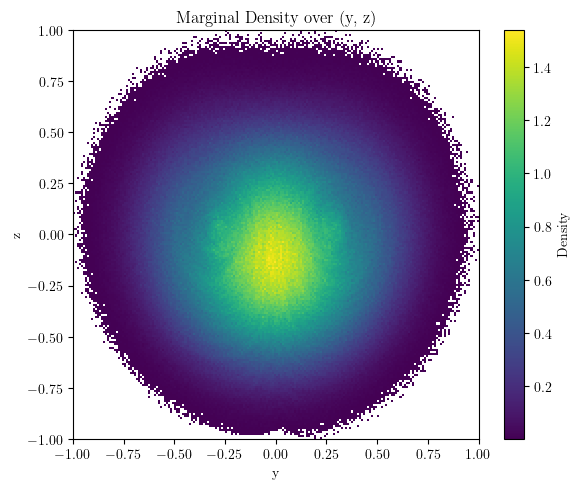

In [92]:
# Bin centers in y and z

marginal_yz = np.sum(hist, axis=0) * dx # shape (ny, nz)
marginal_yz[marginal_yz < 0.0002] = np.NaN
plt.figure(figsize=(6, 5))
plt.pcolormesh(
    y_centers, z_centers, marginal_yz.T,
    shading='auto', cmap='viridis'
)
plt.xlabel("y")
plt.ylabel("z")
plt.title("Marginal Density over (y, z)")
plt.colorbar(label="Density")
plt.tight_layout()
plt.show()